Find Players with low potentials but high actual Rating
- Label Players has a potential higher than 83 but never reaches this potential

In [118]:
HYPERTRAINING = False
CV = 5
SCORING = ''
SAVE_MODEL_NAME = 'offense_regressor'
CLASS_WEIGHTS = 'balanced'
EXPERIEMENT_NAME = "offense_potential_predictor_regression_model_selection"
RUN_NAME = None
TARGET_OVERALL = 80

PLAYER_ATTRIBUTES = [ 'central','winger','offense','Finishing',  'ShortPassing', 'Volleys', 'Dribbling',  'FKAccuracy', 'LongPassing', 'BallControl',
                      'Acceleration', 'SprintSpeed', 'Agility',    'Reactions', 'Balance', 
                      'ShotPower', 'Jumping',  'LongShots', 'Positioning', 'Vision' ]
# PLAYER_ATTRIBUTES = [ 'Age' ,'Dribbling',  'FKAccuracy',  'BallControl','ShotPower','Positioning', 'Penalties' ]
PLAYER_ATTRIBUTES = [  'central','offense','Age','Crossing', 'Finishing', 'HeadingAccuracy', 'ShortPassing', 'Volleys', 'Dribbling', 'Curve', 'FKAccuracy', 'LongPassing', 'BallControl',
                      'Acceleration', 'SprintSpeed', 'Agility', 'GKPositioning', 'GKReflexes', 'Composure', 'Defensive awareness', 'Reactions', 'Balance', 
                      'ShotPower', 'Jumping', 'Stamina', 'Strength', 'LongShots', 'Aggression', 'Interceptions', 'Positioning', 'Vision', 'Penalties', 'Marking', 
                      'StandingTackleshooting_technique', 'SlidingTackle', 'GKDiving', 'GKHandling', 'GKKicking']
PLAYER_ATTRIBUTES = ['Reactions', 'age_based_Stamina', 'Positioning', 'ShortPassing',  'Dribbling', 'BallControl',    'Aggression',   'Vision',  'SprintSpeed','shooting']
PLAYER_ATTRIBUTES = ['Crossing', 'Finishing','shooting_technique','mental'
       'ShortPassing', 'Volleys', 'Dribbling', 'Curve', 'FKAccuracy',
       'LongPassing', 'BallControl',  'SprintSpeed', 'Agility',
       'Reactions', 'Balance', 'ShotPower', 'Jumping', 'Stamina', 'Strength',
       'LongShots', 'Aggression',  'Positioning', 'Vision',
       'Penalties',  
        'youth_player', 'shooting', 
       'mental', 'physique', 'Speed', 'ball_handling', 'age_based_Reactions',
       'age_based_physique', 'age_based_shooting_technique',
       'age_based_Stamina', 'age_based_Positioning', 'age_based_Vision',
       'age_based_Finishing', 'age_based_BallControl']

PLAYER_ATTRIBUTES = [ 'Finishing','FKAccuracy','ShortPassing','Dribbling','BallControl',
                     'Speed',  'Reactions', 'Aggression','mental','age_based_Stamina','Positioning', 'Vision']


In [119]:
import os
import pandas as pd
import numpy as np
import sys
import os

def find_and_append_module_path():
    current_dir = os.getcwd()
    substring_to_find = 'statsfaction'
    index = current_dir.rfind(substring_to_find)
    
    if index != -1:
        # Extract the directory path up to and including the last "mypath" occurrence
        new_dir = current_dir[:index + (len(substring_to_find))]

        # Change the current working directory to the new directory
        os.chdir(new_dir)
        sys.path.append(new_dir)
        # Verify the new current directory
        print("New current directory:", os.getcwd())
    else:
        print("No 'mypath' found in the current directory")
find_and_append_module_path()
os.getcwd()

from src.sport_analytics.model.prepare import add_features_raw_datadf_raw
from src.sport_analytics.model.eval import plot_feature_importance,plot_shap_summary,plot_auc_curves
import config as CONFIG

New current directory: c:\Users\Robert\Documents\Projekte\dev\statsfaction


### Get Data

In [120]:
sql_prime = """
SELECT max(Age) as prime_age,* FROM(SELECT MAX(Overall) AS PrimeOverall,*
  FROM fifa
  GROUP BY ID ) 
  GROUP BY ID
  order by PrimeOverall DESC;
"""

sql_potentials = f"""
SELECT min(Age) as potential_age,* FROM  (SELECT *,Potential as max_potential FROM fifa WHERE Potential>={TARGET_OVERALL})
GROUP BY ID
order by potential DESC;
"""



In [121]:
%load_ext autoreload
%autoreload 2
import pandas as pd
import sqlite3
DATABASE_PATH = "data/sport_analytics/database/football.db"
# Step 1: Establish a database connection
conn = sqlite3.connect(DATABASE_PATH)

df_potentials = pd.read_sql_query(sql_potentials, conn)
df_prime = pd.read_sql_query(sql_prime, conn)

conn.close()

df_potentials = df_potentials.set_index(['ID'])
df_prime = df_prime.set_index(['ID'])

df_raw = df_potentials.join(df_prime[["prime_age","PrimeOverall"]])
df_raw = df_raw.reset_index(['ID'])
df_raw = add_features_raw_datadf_raw(df_raw)

df_raw.head()


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


,,,potential_age,Age,Photo,Nationality,Flag,Overall,Potential,Club,Club Logo,Value,...,ball_handling,age_based_Reactions,age_based_physique,age_based_shooting_technique,age_based_Stamina,age_based_Positioning,age_based_Vision,age_based_Finishing,age_based_BallControl,age_based_shooting
ID,Name,FIFA,,,,,,,,,,,,,,,,,,,,,
158023,L. Messi,2011,23.0,23.0,https://cdn.sofifa.net/players/158/023/11_60.png,Argentina,https://cdn.sofifa.net/flags/ar.png,90.0,95.0,FC Barcelona,https://cdn.sofifa.net/meta/team/83/30.png,€0,...,94.2,15.742424,-4.863636,26.616667,1.750000,30.401515,22.386364,35.196970,25.765152,31.424242
20801,Cristiano Ronaldo,2011,25.0,25.0,https://cdn.sofifa.net/players/020/801/11_60.png,Portugal,https://cdn.sofifa.net/flags/pt.png,89.0,94.0,Real Madrid,https://cdn.sofifa.net/meta/team/3468/30.png,€0,...,92.2,13.169643,8.799107,26.707143,10.535714,26.562500,9.500000,30.133929,23.366071,28.907738
244778,Trincão,2021,20.0,20.0,https://cdn.sofifa.net/players/244/778/21_60.png,Portugal,https://cdn.sofifa.net/flags/pt.png,78.0,91.0,FC Barcelona,https://cdn.sofifa.net/meta/team/83/30.png,€34M,...,80.2,12.425926,9.250000,16.803704,9.037037,15.351852,15.092593,19.259259,14.574074,15.234568
183277,E. Hazard,2011,19.0,19.0,https://cdn.sofifa.net/players/183/277/11_60.png,Belgium,https://cdn.sofifa.net/flags/be.png,81.0,91.0,LOSC Lille,https://cdn.sofifa.net/meta/team/690/30.png,€0,...,83.0,11.125000,-0.210227,16.313636,6.477273,22.250000,21.750000,22.977273,18.102273,19.503788
243812,Rodrygo,2021,19.0,19.0,https://cdn.sofifa.net/players/243/812/21_60.png,Brazil,https://cdn.sofifa.net/flags/br.png,79.0,90.0,Real Madrid,https://cdn.sofifa.net/meta/team/3468/30.png,€38M,...,83.2,17.019608,0.872549,23.164706,16.372549,28.725490,14.196078,28.137255,15.431373,28.457516


# 

In [122]:
df = df_raw.copy()

year_to_category = {2011: 'drop', 2012: 'train', 2013: 'train', 2014: 'train', 2015: 'train', 2016: 'train', 2017: 'train', 2018: 'train', 2019: 'test', 2020: 'test', 2021: 'test', 2022: 'test', 2023: 'valid', 2024: 'valid'}
df['set'] = df.index.get_level_values('FIFA').values
# Apply the mapping to the "FIFA" column
df['set'] = df['set'].map(year_to_category)

df_potentials = df[(df.set=="valid")&(df.Overall<TARGET_OVERALL)&(df.Age<26)&(df.Potential>=TARGET_OVERALL)]

In [123]:

df = df[df.prime_age>df.potential_age]
df['target'] = df.PrimeOverall
df = df[df.potential_age<26]
df = df[df.offense>0.5]
print(df.target.value_counts())
PREDICTION_NAME = "Offense"

df_processed = df.copy()

target
77.0    77
78.0    63
75.0    61
76.0    52
79.0    47
73.0    47
74.0    46
81.0    39
71.0    37
70.0    35
80.0    35
72.0    33
83.0    31
68.0    30
84.0    30
82.0    28
67.0    24
69.0    24
64.0    15
66.0    14
85.0    12
65.0    10
87.0     9
86.0     7
88.0     6
90.0     6
89.0     6
62.0     4
91.0     4
63.0     4
92.0     3
61.0     2
94.0     2
57.0     1
58.0     1
Name: count, dtype: int64


In [124]:
df[["potential_age","Age","prime_age","max_potential","Potential","Overall","PrimeOverall","target","set","best_position"]].head()

,,,potential_age,Age,prime_age,max_potential,Potential,Overall,PrimeOverall,target,set,best_position
ID,Name,FIFA,,,,,,,,,,
158023,L. Messi,2011,23.0,23.0,24.0,95.0,95.0,90.0,94.0,94.0,drop,RW
20801,Cristiano Ronaldo,2011,25.0,25.0,31.0,94.0,94.0,89.0,94.0,94.0,drop,RW
183277,E. Hazard,2011,19.0,19.0,27.0,91.0,91.0,81.0,91.0,91.0,drop,RW
243812,Rodrygo,2021,19.0,19.0,21.0,90.0,90.0,79.0,81.0,81.0,test,RW
208790,Z. Bakkali,2014,17.0,17.0,20.0,90.0,90.0,73.0,74.0,74.0,train,RW


In [125]:
# if True:
#     df = df[[any(pos in i for pos in ['CF', 'LW', 'ST', 'RW']) for i in df['Position']]]
#     df.shape
# else:
#     select_position = lambda x: x in ["ST","CF","LW","RW"]
#     df["select"] = df['Position'].apply(select_position)
#     df = df[df["select"]]
#     df.shape

###  Feature Engineering

In [126]:
df_processed.columns[df_processed.isna().sum()>0]

Index(['Club', 'Marking', 'Composure', 'Defensive awareness', 'mental'], dtype='object')

#### Transform Value

In [127]:
df_processed = df_processed.fillna(0)
df_potentials = df_potentials.fillna(0)

<Axes: >

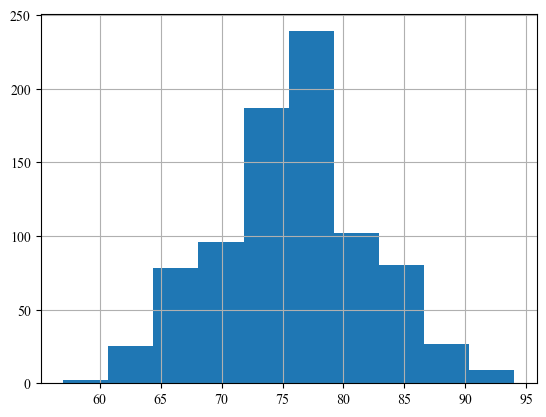

In [128]:
df['target'].hist()

In [129]:
X = df_processed.drop("target", axis=1, errors='ignore')
y = df['target']  # Use df_processed here instead of df
# Split the data into training and testing sets

In [130]:


from sklearn.model_selection import train_test_split
if False:
    # Step 1: Split the data into training and testing sets
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

    X_train = X_train[PLAYER_ATTRIBUTES]
    X_test = X_test[PLAYER_ATTRIBUTES]

else:

    X_train = X[X.set=="train"][PLAYER_ATTRIBUTES]
    y_train = y[X.set=="train"]

    X_test = X[X.set=="test"][PLAYER_ATTRIBUTES]
    y_test = y[X.set=="test"]


In [131]:
y_train.describe()

count    383.000000
mean      76.671018
std        5.397922
min       57.000000
25%       73.000000
50%       77.000000
75%       80.000000
max       92.000000
Name: target, dtype: float64

In [132]:
import warnings

# Ignore all warnings
warnings.filterwarnings("ignore")
# Load your dataset or replace df_processed and df with your data
# df_processed = pd.read_csv('your_dataset.csv')

import pandas as pd

from sklearn.preprocessing import StandardScaler
# Step 2: Initialize a StandardScaler
scaler = StandardScaler()

# Step 3: Fit the scaler on the training data and transform both training 
# and testing data
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

df_potentials_scaled = scaler.transform(df_potentials[PLAYER_ATTRIBUTES].fillna(0))

# Step 4: Create new DataFrames with the scaled data while preserving the index and columns
X_train_scaled_df = pd.DataFrame(X_train_scaled, index=X_train.index, columns=PLAYER_ATTRIBUTES)
X_test_scaled_df = pd.DataFrame(X_test_scaled, index=X_test.index, columns=PLAYER_ATTRIBUTES)
df_potentials_scaled_df = pd.DataFrame(df_potentials_scaled, index=df_potentials.index, columns=PLAYER_ATTRIBUTES)

# Hyperparametertuning

In [133]:
import optuna
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import roc_auc_score
from sklearn.model_selection import cross_val_score

if HYPERTRAINING:
    def objective(trial):
        # Define hyperparameters to optimize
        params = {
            'n_estimators': trial.suggest_int('n_estimators', 100, 500),
            'max_depth': trial.suggest_int('max_depth', 1, 8),
            'min_samples_split': trial.suggest_float('min_samples_split', 0.1, 1.0),  # Adjust the range
            'min_samples_leaf': trial.suggest_float('min_samples_leaf', 0.1, 0.5),  # Adjust the range
            'max_features': trial.suggest_float('max_features', 0.6, 1.0),
            'criterion': 'entropy',  # or 'entropy' depending on your problem
            'random_state': 42
        }

        # Implement cross-validation
        cv_scores = cross_val_score(RandomForestClassifier(**params), X_train_scaled_df, y_train, cv=CV, scoring=SCORING)
        mean_auc = cv_scores.mean()

        return mean_auc

    # Create an Optuna study for maximizing AUC
    study = optuna.create_study(direction='maximize')
    study.optimize(objective, n_trials=100)  # You can increase n_trials for more optimization

    PARAMS_RF = study.best_params
    best_auc = study.best_value

    print("Best hyperparameters:", PARAMS_RF)
    print(f"Best {SCORING}:", best_auc)
else:
    PARAMS_RF = {}

In [134]:
import optuna
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import roc_auc_score
from sklearn.model_selection import cross_val_score

if HYPERTRAINING:
    def objective(trial):
        # Define hyperparameters to optimize
        params = {
            'max_depth': trial.suggest_int('max_depth', 1, 12),
            'min_samples_split': trial.suggest_float('min_samples_split', 0.1, 1.0),  # Adjust the range
            'min_samples_leaf': trial.suggest_float('min_samples_leaf', 0.1, 0.5),  # Adjust the range
            'max_features': trial.suggest_float('max_features', 0.1, 1.0),
            'criterion': 'gini',  # or 'entropy' depending on your problem
            'random_state': 42
        }

        # Create the Decision Tree classifier with the given hyperparameters
        clf = DecisionTreeClassifier(**params)

        # Implement cross-validation to calculate mean AUC
        cv_scores = cross_val_score(clf, X_train_scaled_df, y_train, cv=CV, scoring='recall_macro')
        mean_auc = cv_scores.mean()

        return mean_auc

    # Create an Optuna study for maximizing AUC
    study = optuna.create_study(direction='maximize')
    study.optimize(objective, n_trials=100)  # You can increase n_trials for more optimization

    PARAM_DT = study.best_params
    best_auc = study.best_value

    print("Best hyperparameters:", PARAM_DT)
    print(f"Best {SCORING}:", best_auc)
else:
    PARAM_DT = {}

In [135]:
import optuna
import xgboost as xgb
from sklearn.metrics import roc_auc_score
from xgboost import XGBClassifier
from sklearn.model_selection import cross_val_score

if HYPERTRAINING:
    def objective(trial):
        # Define hyperparameters to optimize
        params = {
            'objective': 'binary:logistic',
            'learning_rate': trial.suggest_uniform('learning_rate', 0.01, 0.3),
            'max_depth': trial.suggest_int('max_depth', 3, 10),
            'min_child_weight': trial.suggest_uniform('min_child_weight', 1.0, 20.0),
            'n_estimators': trial.suggest_int('n_estimators', 100, 300),
            'subsample': trial.suggest_uniform('subsample', 0.7, 1.0),
            'reg_alpha': trial.suggest_uniform('reg_alpha', 0.1, 1.0),
            'reg_lambda': trial.suggest_uniform('reg_lambda', 0.01, 0.1),
            'colsample_bytree': trial.suggest_uniform('colsample_bytree', 0.6, 1.0),
        }
        # Implement early stopping with cross-validation
        cv_scores = []

        clf = XGBClassifier(**params, random_state=42, n_jobs=-1)
        # Implement cross-validation to calculate mean AUC
        cv_scores = cross_val_score(clf, X_train_scaled_df, y_train, cv=CV, scoring=SCORING)
        mean_auc = cv_scores.mean()

        return mean_auc
    # Create an Optuna study for maximizing AUC
    study = optuna.create_study(direction='maximize')
    study.optimize(objective, n_trials=100)  # You can increase n_trials for more optimization

    PARAM_XGB = study.best_params
    best_auc = study.best_value

    print("Best hyperparameters:", PARAM_XGB)
    print(f"Best {SCORING}:", best_auc)
else:
    PARAM_XGB = {}


# TODOS
- SHAP Values for Regression Models -> DONE
- SCV and Logistic Regression
- Hyperparameter Tuning
- classification model einbauen -> DONE
- Make Usable in Deployment 

2023/11/25 17:30:52 INFO mlflow.tracking.fluent: Experiment with name 'offense_potential_predictor_regression_model_selection' does not exist. Creating a new experiment.


Linear Regression training----->


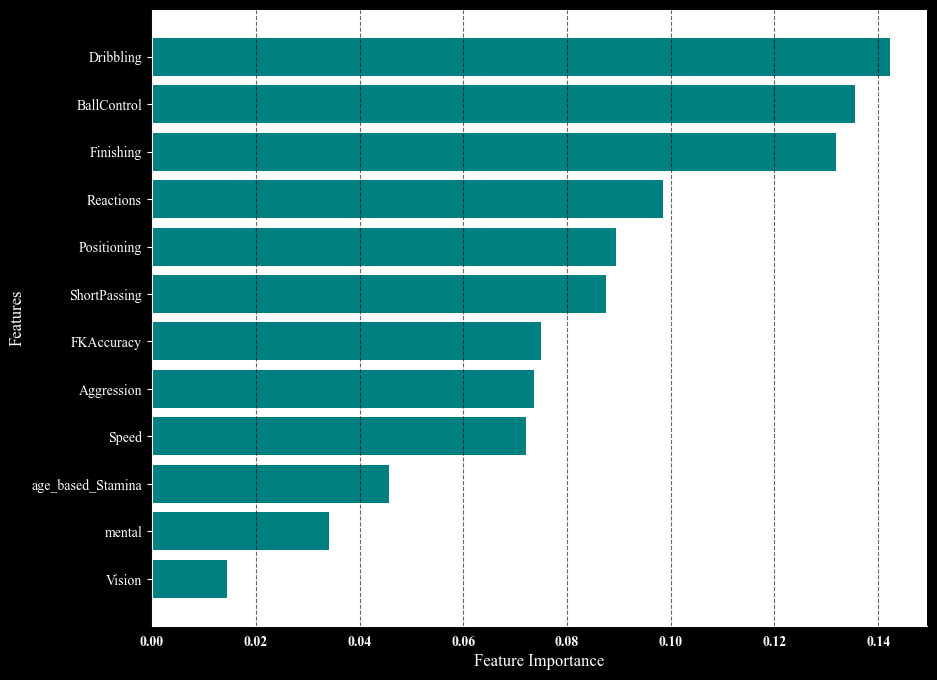

Using 234 background data samples could cause slower run times. Consider using shap.sample(data, K) or shap.kmeans(data, K) to summarize the background as K samples.
100%|██████████| 30/30 [00:54<00:00,  1.82s/it]


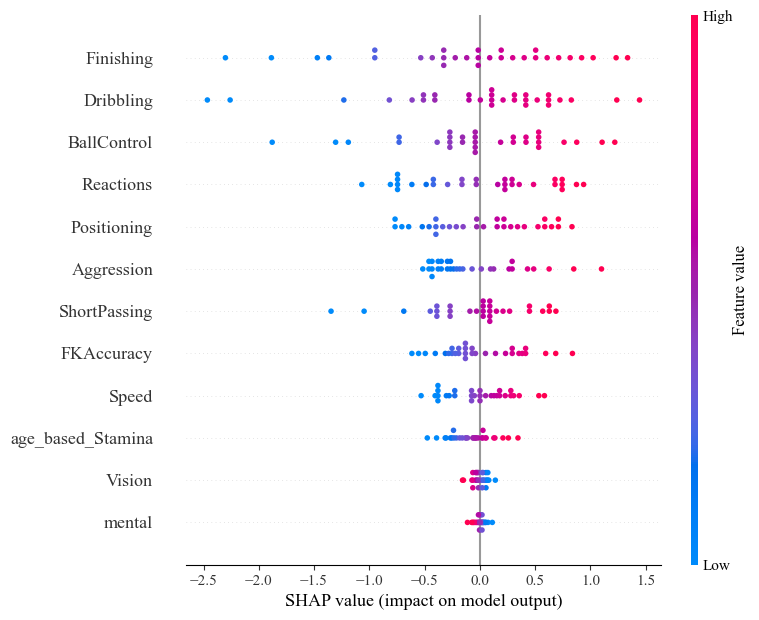

              precision    recall  f1-score   support

       False       0.92      0.99      0.95       211
        True       0.62      0.22      0.32        23

    accuracy                           0.91       234
   macro avg       0.77      0.60      0.64       234
weighted avg       0.89      0.91      0.89       234

Ridge Regression training----->


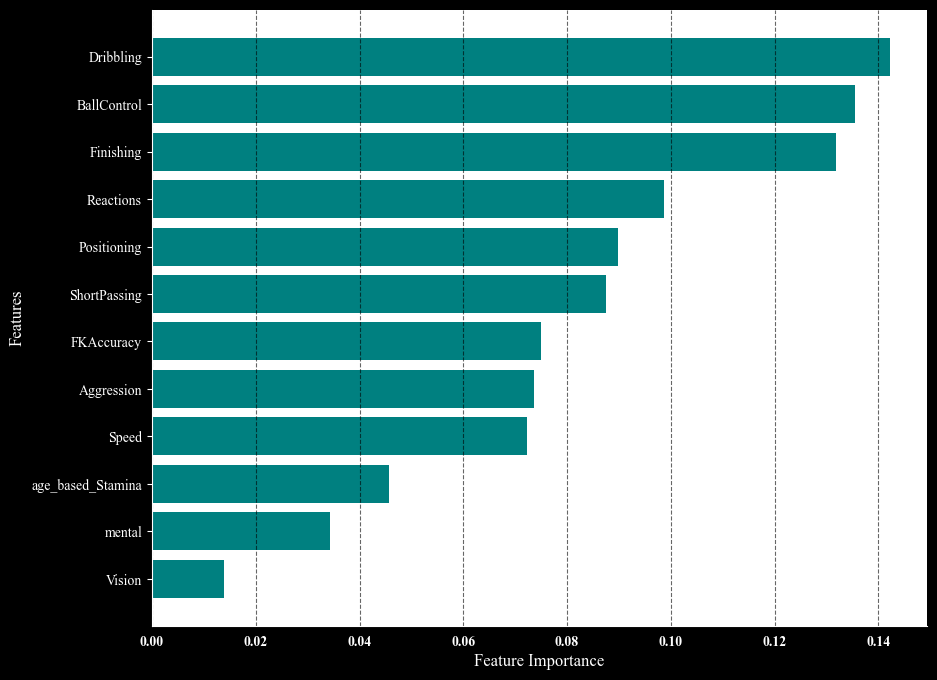

Using 234 background data samples could cause slower run times. Consider using shap.sample(data, K) or shap.kmeans(data, K) to summarize the background as K samples.
100%|██████████| 30/30 [01:09<00:00,  2.30s/it]


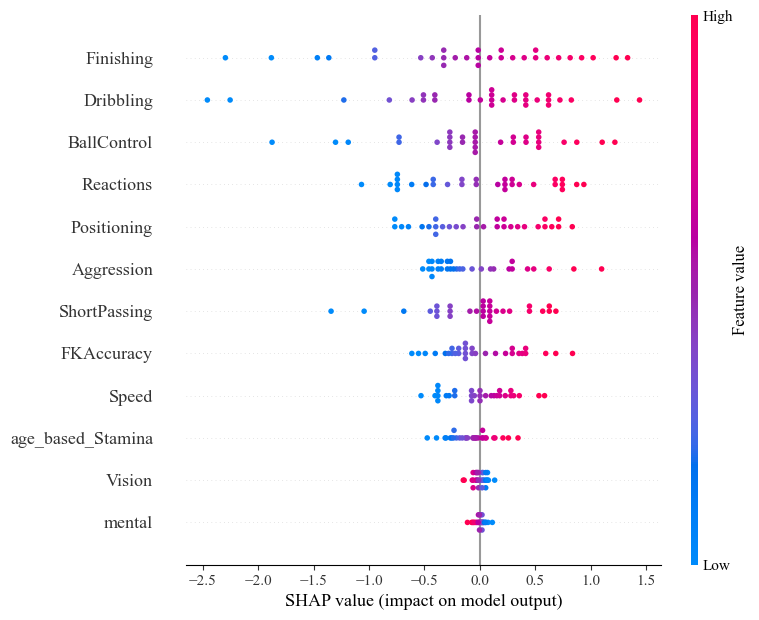

              precision    recall  f1-score   support

       False       0.92      0.99      0.95       211
        True       0.62      0.22      0.32        23

    accuracy                           0.91       234
   macro avg       0.77      0.60      0.64       234
weighted avg       0.89      0.91      0.89       234

Lasso Regression training----->


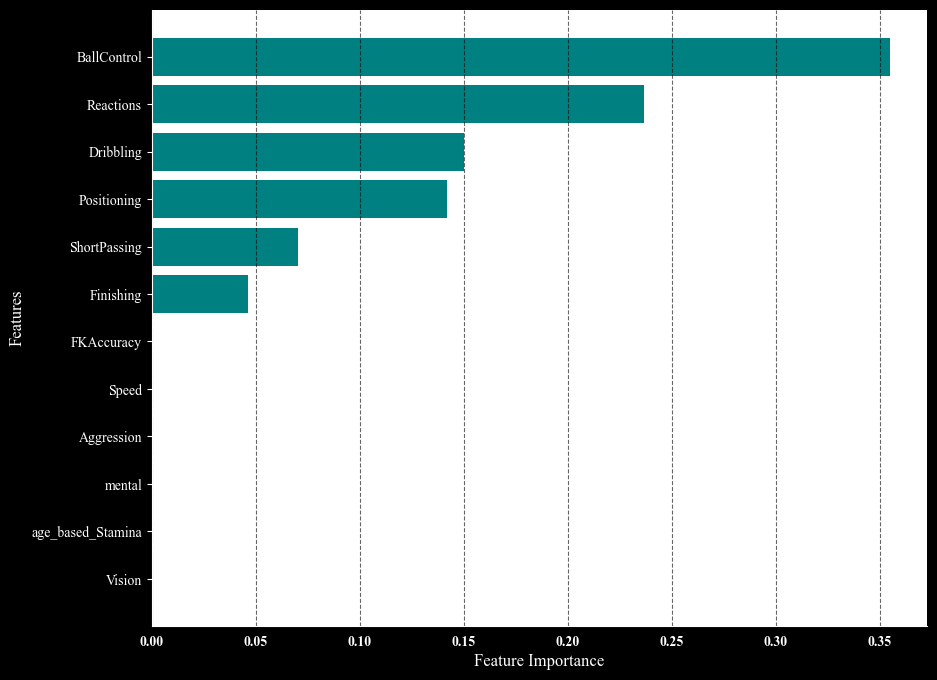

Using 234 background data samples could cause slower run times. Consider using shap.sample(data, K) or shap.kmeans(data, K) to summarize the background as K samples.
100%|██████████| 30/30 [01:02<00:00,  2.09s/it]


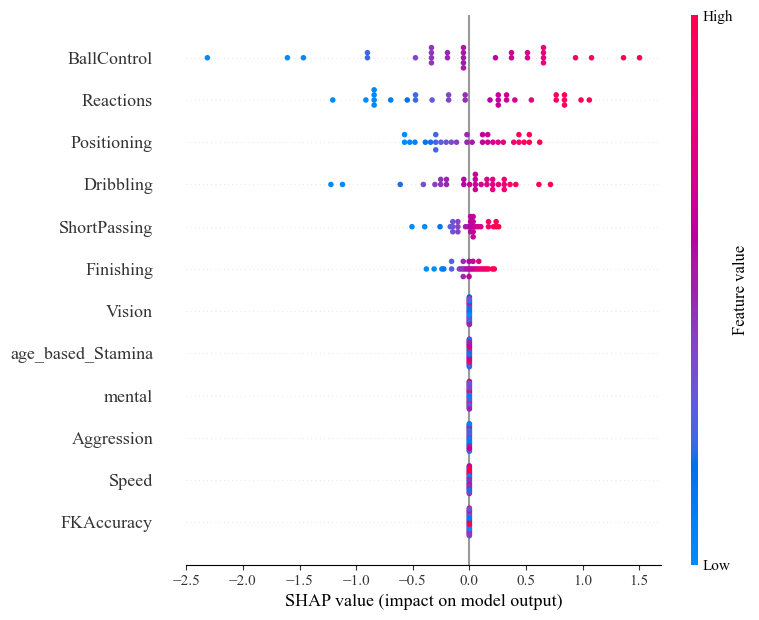

              precision    recall  f1-score   support

       False       0.91      1.00      0.95       211
        True       1.00      0.09      0.16        23

    accuracy                           0.91       234
   macro avg       0.95      0.54      0.56       234
weighted avg       0.92      0.91      0.87       234

ElasticNet Regression training----->


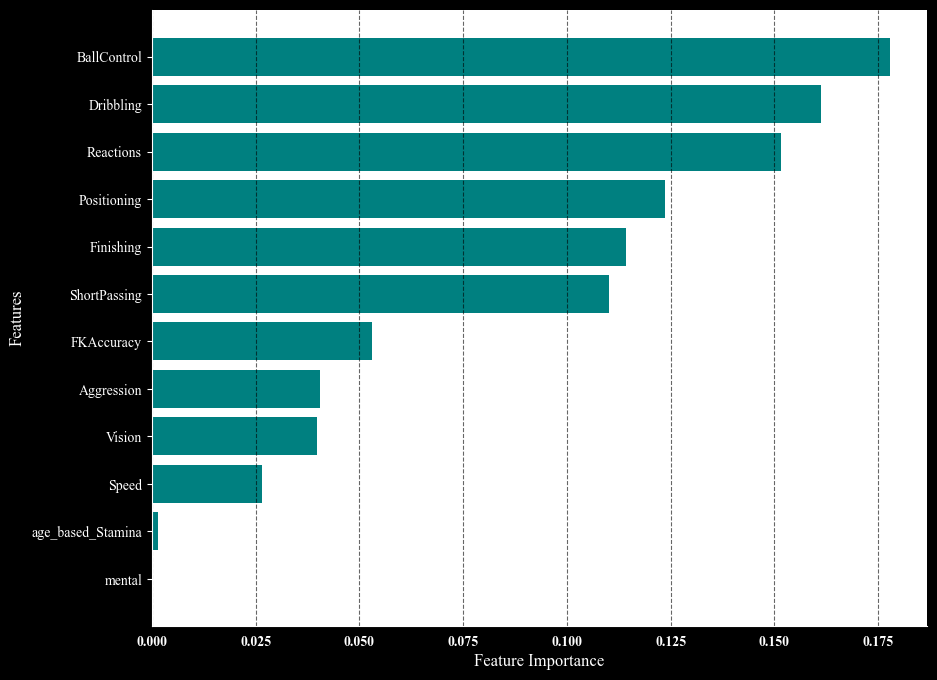

Using 234 background data samples could cause slower run times. Consider using shap.sample(data, K) or shap.kmeans(data, K) to summarize the background as K samples.
100%|██████████| 30/30 [01:01<00:00,  2.05s/it]


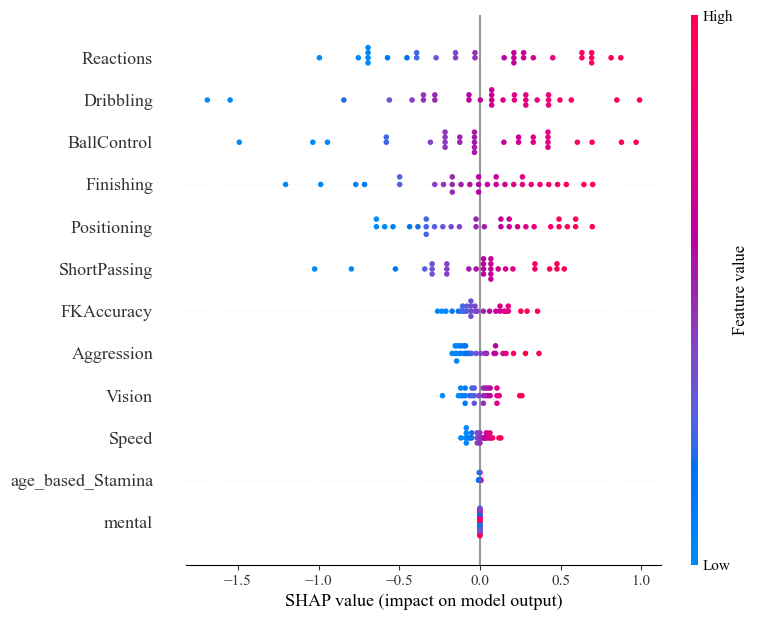

              precision    recall  f1-score   support

       False       0.92      1.00      0.96       211
        True       1.00      0.17      0.30        23

    accuracy                           0.92       234
   macro avg       0.96      0.59      0.63       234
weighted avg       0.93      0.92      0.89       234

K-Nearest Neighbors Regressor training----->


ValueError: Model does not have feature importances.

In [136]:
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.svm import SVR
import xgboost as xgb
import lightgbm as lgb

from src.sport_analytics.model.eval import plot_feature_importance, log_metrics_in_mlflow_regression,log_metrics_in_mlflow, log_feature_list_as_artifact, plot_shap_summary
from src.sport_analytics.utils import *
import mlflow
import mlflow.sklearn
import mlflow.xgboost
import mlflow.lightgbm
import pandas as pd
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score



from sklearn.linear_model import Ridge, Lasso, ElasticNet
from sklearn.svm import SVR
from sklearn.neighbors import KNeighborsRegressor
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.neural_network import MLPRegressor
from sklearn.ensemble import AdaBoostRegressor

regression_models = {
    'Ridge Regression': Ridge(),
    'AdaBoost Regressor': AdaBoostRegressor(random_state=42),

    'Lasso Regression': Lasso(),
    'ElasticNet Regression': ElasticNet(),
    'Linear Regression': LinearRegression(),
    'Random Forest Regressor': RandomForestRegressor(random_state=42),
    'Gradient Boosting Regressor': GradientBoostingRegressor(random_state=42),
    'XGBoost Regressor': xgb.XGBRegressor(random_state=42),
    'LightGBM Regressor': lgb.LGBMRegressor(random_state=42)
    # Add more models as needed
}


regression_results = {}
import datetime
# Set the experiment name
mlflow.set_experiment(EXPERIEMENT_NAME)

# Start MLflow run with a specific run name and description
for model_name, model in regression_models.items():
    from datetime import datetime

    # Get the current timestamp
    timestamp = datetime.now().strftime("%Y%m%d%H%M%S")
    with mlflow.start_run(run_name=f"{model_name}_{timestamp}"):

        print(model_name, "training----->")

        # Log parameters
        mlflow.log_param("Model_Name", model_name)
        mlflow.log_params(model.get_params())

        model.fit(X_train_scaled_df, y_train)
       
        y_pred = model.predict(X_test_scaled_df)
        
        # Log Params
        log_feature_list_as_artifact(PLAYER_ATTRIBUTES, filename="feature_list.txt")

        # Create a dictionary with parameters and their values
        params_to_log = {
            'HYPERTRAINING': HYPERTRAINING,
            'CV': CV,
            'SCORING': SCORING,
            'features_anzahl': len(PLAYER_ATTRIBUTES),
            # 'y_train_positives': y_train.sum(),
            # 'y_train_negatives': (~y_train).sum(),
            # 'y_test_positives': y_test.sum(),
            # 'y_test_negatives': (~y_test).sum(),
            'TARGET_OVERALL': TARGET_OVERALL
        }

        # Log parameters using log_params
        mlflow.log_params(params_to_log)

        # Log artifacts
        mlflow.sklearn.log_model(model, model_name)

        # Evaluation Metrics
        log_metrics_in_mlflow_regression(y_test=y_test, y_pred=y_pred)
        log_metrics_in_mlflow(y_test=y_test>TARGET_OVERALL,y_prob=None,y_pred=y_pred>TARGET_OVERALL)

        # Evaluation Plots (Note: Regression models may not have ROC curves, so adapt this as needed)
        plot_feature_importance(model, '', top_n=20)
        plot_shap_summary(model=model,df=X_test_scaled_df,K = 30)

        # Output for quick evaluation
        mse = mean_squared_error(y_test, y_pred)
        mae = mean_absolute_error(y_test, y_pred)
        r2 = r2_score(y_test, y_pred)
        
        from sklearn.metrics import  classification_report
        report = classification_report(y_test>TARGET_OVERALL, y_pred>TARGET_OVERALL)
        print(report)

     
        regression_results[model_name] = {
            'Model': model,
            'Scaler': scaler,
            'attributes': PLAYER_ATTRIBUTES,
            'Classification Report': report,
            'Mean Squared Error': mse,
            'Mean Absolute Error': mae,
            'R2 Score': r2
        }

# Evaluate and print results for each model
for model_name, results in regression_results.items():
    print(f"Model: {model_name}")
    print(f"Mean Squared Error: {results['Mean Squared Error']:.2f}")
    print(f"Mean Absolute Error: {results['Mean Absolute Error']:.2f}")
    print(f"R2 Score: {results['R2 Score']:.2f}")
    print()




In [ ]:
from src.sport_analytics.model.utils import *
if SAVE_MODEL_NAME!="":
    save_dict_as_pickle(data_dict = regression_results, file_path=f"{CONFIG.TRAINED_MODELS}/{SAVE_MODEL_NAME}.pkl")

# evaluate Model

In [ ]:
y_test.describe()

In [ ]:
my_model = regression_results['Linear Regression']['Model']


In [ ]:
result_df = pd.Series(my_model.predict(X_test_scaled_df),index=X_test_scaled_df.index)
len(result_df)

In [ ]:
bool_ = (result_df>=78)&(y_test>=78)
print(bool_.sum())
result_df[bool_]

In [ ]:
bool_ = (result_df<78)&(y_test>=78)
print(bool_.sum())
result_df[bool_]

In [ ]:
bool_ = (result_df>=78)&(y_test<=78)
print(bool_.sum())
result_df[bool_]

In [ ]:
bool_ = (result_df<=78)&(y_test>78)
print(bool_.sum())
result_df[bool_]

In [ ]:
bool_ = (result_df<78)&(y_test<78)
print(bool_.sum())
result_df[bool_].sort_values().tail(20)

In [ ]:
from sklearn.metrics import  classification_report
print(classification_report(y_test>78, result_df>78))